# <font color='blue'>Movie Recommender - Machine Learning</font>

In [142]:
# Versão da Linguagem Python
from platform import python_version
print('Python Version:', python_version())

Python Version: 3.11.5


This portfolio project centers on creating a Netflix movie recommendation system as a demonstration of a data analyst's proficiency. By delving into user ratings, movie data, and collaborative filtering, the system tailors movie suggestions based on user preferences and viewing history.

The project starts with Exploratory Data Analysis (EDA) to glean insights into user behavior, movie popularity, and rating patterns. Visualizations provide a snapshot of user engagement, rating distributions, and key trends in the dataset.

Implementation involves constructing a sparse matrix to capture user-movie interactions, accommodating Netflix's extensive library and diverse user base. Techniques like collaborative filtering and matrix factorization uncover latent factors shaping user choices. Dimensionality reduction, like Singular Value Decomposition (SVD), enhances model efficiency.

## Data Source

The Netflix Prize was a competition launched by Netflix in 2006, challenging participants to improve the accuracy of its recommendation algorithm by at least 10%. The dataset for this competition contains information about user ratings for various movies. Some key details include:

User Ratings: The dataset includes user ratings for movies on a numerical scale.

Movie Information: It contains information about the movies, such as their titles, release years, and possibly other metadata.

User IDs: Each user is typically identified by a unique user ID.

Time Information: The dataset may include timestamps indicating when the ratings were given.

Training and Testing Sets: In a typical machine learning competition setup, the dataset is divided into training and testing sets. Participants use the training set to develop their models and then submit predictions for the testing set to evaluate the model's performance.

<ul>
<li> <a href="https://www.netflixprize.com/rules.html">Netflix Prize</a></li>
<li> <a href="https://www.kaggle.com/netflix-inc/netflix-prize-data">Dataset</a></li>

## Installing and loading packages

In [143]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
%matplotlib inline

# Formatação dos gráficos
matplotlib.use('nbagg')
plt.rcParams.update({'figure.max_open_warning': 0})
sns.set_style('whitegrid')

In [144]:
#scipy     : 1.11.1
#pandas    : 2.0.3
#numpy     : 1.24.3
#seaborn   : 0.12.2
#sklearn   : 1.3.0
#matplotlib: 3.7.2

## Loading the Data
To load the data, we will perform the following operations:

1- Read the lines from all available files.
2- Combine all the lines from all files into a single file.
3- Load the generated file into a pandas dataframe.

In [145]:
# Initial reading time
start = datetime.now()

In [146]:
# We will create a final file called data.csv

# If the file does not exist, we create the file in write mode (w)
if not os.path.isfile('data/data.csv'):
    
    # Create and open the file for writing
    dataset = open('data/data.csv', mode='w')
    
    # List for file lines
    lines = list()
    
    # Names and paths of the files
    files = ['data/combined_data_1.txt',
             'data/combined_data_2.txt',
             'data/combined_data_3.txt',
             'data/combined_data_4.txt']
    
    # Loop through each file in the files list
    for file in files:
        
        # Print
        print("Reading file {}...".format(file))
        
        # With the file open, extract the lines
        with open(file) as f:
            
            # Loop through each line of the file
            for line in f: 
                
                # Delete the contents of the list
                del lines[:] 
                
                # Split the lines of the file by the newline character
                line = line.strip()
                
                # If we find "colon" at the end of the line, we replace it, removing the character,
                # as we only want the movie ID
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                    
                # If not, create a list comprehension to separate the columns by comma
                else:
                    
                    # Separate the columns
                    lines = [x for x in line.split(',')]
                    
                    # Use the movie ID at index position zero
                    lines.insert(0, movie_id)
                    
                    # Write the result to the new file
                    dataset.write(','.join(lines))
                    dataset.write('\n')
                    
        print("Completed.\n")
        
    dataset.close()

In [147]:
# Print total time
print('Total time to load the files:', datetime.now() - start)

Total time to load the files: 0:00:00.019535


In [148]:
print("Creating dataframe...")
df_netflix = pd.read_csv('data/data.csv', sep = ',', names = ['movie', 'user', 'rating', 'date'])
df_netflix.date = pd.to_datetime(df_netflix.date)
print('Completed.')

Creating dataframe...


Completed.


In [149]:
# Ordering the dataframe by date
print('Ordering the dataframe by date..')
df_netflix.sort_values(by = 'date', inplace = True)
print('Completed.')

Ordering the dataframe by date..
Completed.


In [150]:
# Shape
df_netflix.shape

(100480507, 4)

In [151]:
# Visualizing data
df_netflix.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


Working with 100 million records is not easy, and this can consume a lot of computational resources. Here are some tips:

- 1- Close all files and software on your computer. Keep only what is truly necessary.
- 2- Consider using a cloud environment or even a computer cluster if possible.
- 3- Reduce the size of each file. Here are some software suggestions for "File Splitter":

http://www.fastfilejoiner.com/

https://www.gdgsoft.com/gsplit/download

http://www.kcsoftwares.com/?kfk

## EDA

In [152]:
# Data summary
print("Data summary")
print("-"*50)
print("Total movies/series:", len(np.unique(df_netflix.movie)))
print("Total users:", len(np.unique(df_netflix.user)))
print("Total ratings:", df_netflix.shape[0])

Data summary
--------------------------------------------------


Total movies/series: 17770
Total users: 480189
Total ratings: 100480507


In [153]:
# Savings values to use it later
total_users = len(np.unique(df_netflix.user))
total_movies = len(np.unique(df_netflix.movie))

In [154]:
# Checking the average rating and dist.
df_netflix.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
std      1.085219e+00
Name: rating, dtype: float64

In [155]:
# Checking null values
sum(df_netflix.isnull().any())

0

In [156]:
# Checking duplicates
sum(df_netflix.duplicated(['movie', 'user', 'rating']))

0

Let's split the data into training and testing sets before proceeding with exploratory analysis since some analyses only make sense for the training data. We will use an 80/20 ratio for training/testing.

In [157]:
# We will create a dataset on disk with the training data
# This way, we don't need to execute the entire loading process again each time we run this notebook
if not os.path.isfile('data/train_data.csv'):
    df_netflix.iloc[:int(df_netflix.shape[0] * 0.80)].to_csv("data/train_data.csv", index=False)

In [158]:
# We will create a dataset on disk with the test data
# This way, we don't need to execute the entire loading process again each time we run this notebook
if not os.path.isfile('data/test_data.csv'):
    df_netflix.iloc[int(df_netflix.shape[0] * 0.80):].to_csv("data/test_data.csv", index=False)

In [159]:
# Deleting original dataframe to save space
del df_netflix

In [160]:
# Now we load the files into pandas dataframes
df_netflix_train = pd.read_csv("data/train_data.csv", parse_dates=['date'])
df_netflix_test = pd.read_csv("data/test_data.csv")

In [161]:
# Summary of training data
print("Summary of Training Data")
print("-" * 50)
print("Total Number of Movies:", len(np.unique(df_netflix_train.movie)))
print("Total Number of Users:", len(np.unique(df_netflix_train.user)))
print("Total Number of Ratings:", df_netflix_train.shape[0])

Summary of Training Data
--------------------------------------------------
Total Number of Movies: 17424
Total Number of Users: 405041
Total Number of Ratings: 80384405


In [162]:
# Summary of test data
print("Summary of Test Data")
print("-" * 50)
print("Total Number of Movies:", len(np.unique(df_netflix_test.movie)))
print("Total Number of Users:", len(np.unique(df_netflix_test.user)))
print("Total Number of Ratings:", df_netflix_test.shape[0])

Summary of Test Data
--------------------------------------------------
Total Number of Movies: 17757
Total Number of Users: 349312
Total Number of Ratings: 20096102


A função abaixo vai ajustar as medidas em milhares, milhões e bilhões para facilitar a leitura dos gráficos.

In [163]:
# Unit adjusting function
def adjust_units(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

In [164]:
# Supress warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Checking the ratings distribution

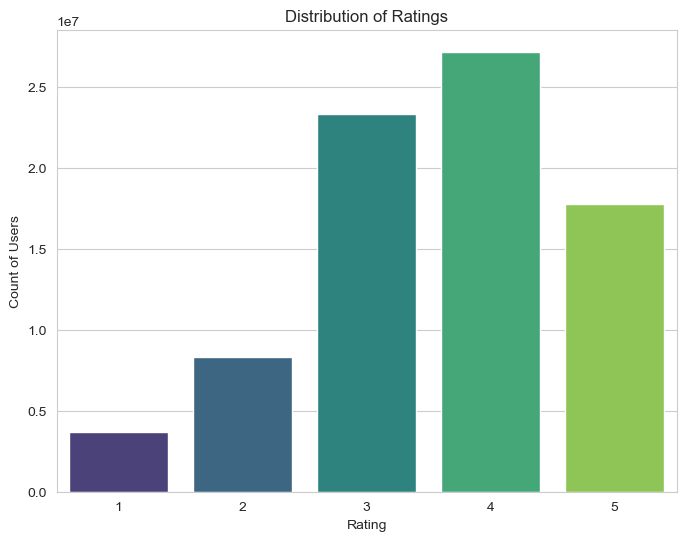

In [224]:
# Plot the distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=df_netflix_train, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count of Users')
plt.show()

__Does the day of the week influence user ratings? Let's include a column with the day of the week and find out.__

In [166]:
# Avoid warning due data volume
pd.options.mode.chained_assignment = None

In [167]:
# Getting weekday
df_netflix_train['weekday'] = df_netflix_train['date'].dt.strftime("%A")
df_netflix_train.head()

,movie,user,rating,date,weekday
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


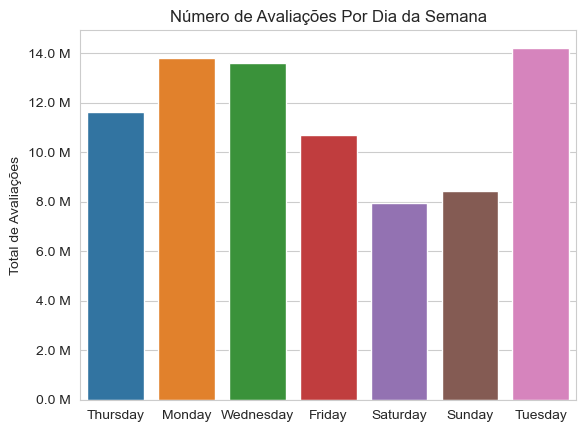

In [168]:
# Plot
%matplotlib inline
fig, ax = plt.subplots()
sns.countplot(x = 'weekday', data = df_netflix_train, ax = ax)
plt.title('Número de Avaliações Por Dia da Semana')
plt.ylabel('Total de Avaliações')
plt.xlabel('')
ax.set_yticklabels([adjust_units(item, 'M') for item in ax.get_yticks()])
plt.show()

__Let's calculate the average ratings per day of the week.__

In [169]:
# Average rating by weekday
weekday_avg = df_netflix_train.groupby(by = ['weekday'])['rating'].mean()
print("Average Rating")
print("-"*30)
print(weekday_avg)
print("\n")

Average Rating
------------------------------
weekday
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64




The day of the week does not seem to have an influence on user ratings.

__Let's analyze user ratings over time.__

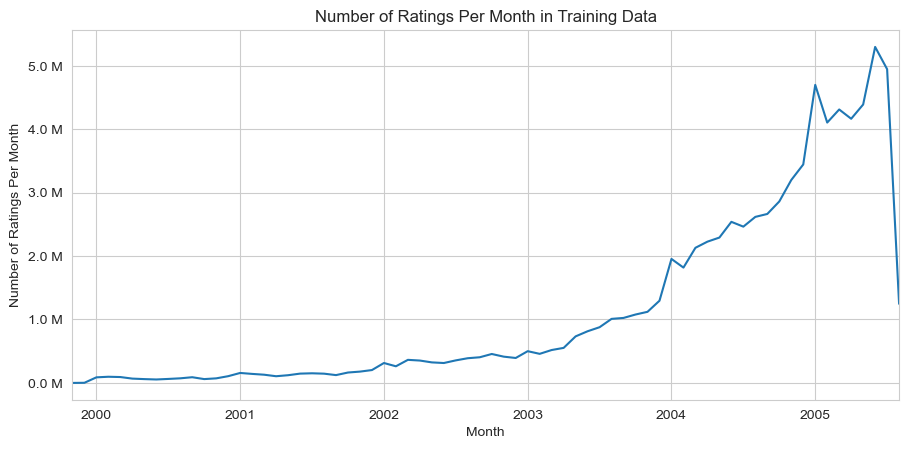

In [170]:
# Plot
%matplotlib inline
fig = plt.figure(figsize=plt.figaspect(.45))
ax = df_netflix_train.resample('m', on='date')['rating'].count().plot()
ax.set_title('Number of Ratings Per Month in Training Data')
plt.xlabel('Month')
plt.ylabel('Number of Ratings Per Month')
ax.set_yticklabels([adjust_units(item, 'M') for item in ax.get_yticks()])
plt.show()

Clearly, there is an increase in user ratings over time, either due to a higher number of users or because users have learned to use the feature.

Let's check the users who have provided the most movie ratings.

In [171]:
# Ammount of ratings per user
num_rat_per_user = df_netflix_train.groupby(by = 'user')['rating'].count().sort_values(ascending = False)
num_rat_per_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

In [172]:
# Stats summary
num_rat_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

"Let's create a plot of the probability density function and cumulative distribution function."

"The probability density function (pdf) and cumulative distribution function (cdf) are two of the most important statistical functions in reliability and are closely related. When these functions are known, almost any other reliability measure of interest can be derived or obtained. More about this can be found here:"

http://reliawiki.org/index.php/Basic_Statistical_Background

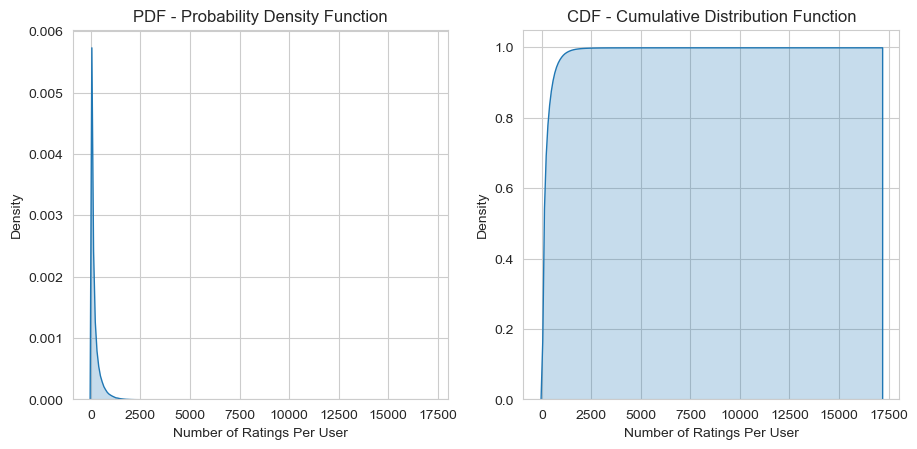

In [173]:
# Plot
%matplotlib inline
fig = plt.figure(figsize=plt.figaspect(.45))

# Probability Density Function (PDF)
ax1 = plt.subplot(121)
sns.kdeplot(num_rat_per_user, shade=True, ax=ax1)
plt.xlabel('Number of Ratings Per User')
plt.title("PDF - Probability Density Function")

# Cumulative Distribution Function (CDF)
ax2 = plt.subplot(122)
sns.kdeplot(num_rat_per_user, shade=True, cumulative=True, ax=ax2)
plt.xlabel('Number of Ratings Per User')
plt.title('CDF - Cumulative Distribution Function')

plt.show()

Note that the vast majority of users have fewer than 1000 ratings.

How many ratings are in the last 5% of all ratings?

In [174]:
# Let's extract the percentiles
percentile = num_rat_per_user.quantile(np.arange(0, 1.01, 0.01), interpolation='higher')

In [175]:
# Viewing every 5th percentile
percentile[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

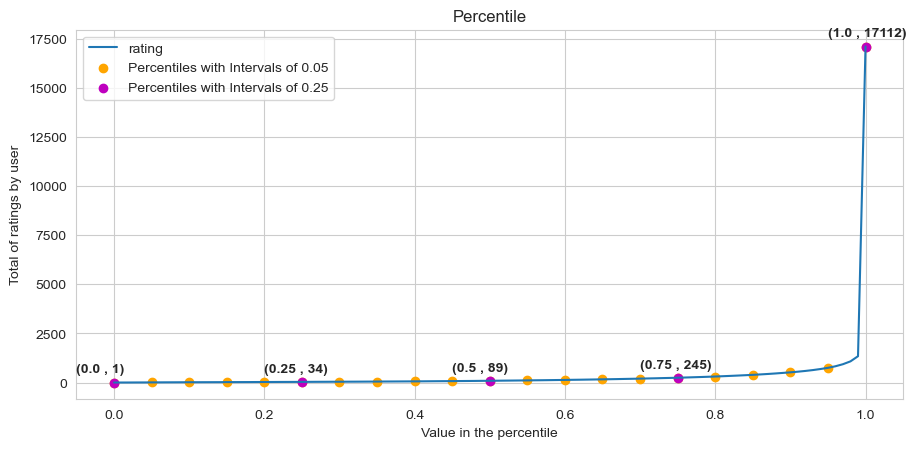

In [226]:
# Plot
fig = plt.figure(figsize=plt.figaspect(.45))
plt.title("Percentile")
percentile.plot()

# Quartis com diferença de 0.05
plt.scatter(x=percentile.index[::5],
            y=percentile.values[::5],
            c='orange',
            label="Percentiles with Intervals of 0.05")

# Quartis com diferença de 0.25
plt.scatter(x=percentile.index[::25],
            y=percentile.values[::25],
            c='m',
            label="Percentiles with Intervals of 0.25")

# Labels e legenda
plt.ylabel('Total of ratings by user')
plt.xlabel('Value in the percentile')
plt.legend(loc='best')

# Vamos marcar os percentis 25, 50, 75 e 100
for x, y in zip(percentile.index[::25], percentile[::25]):
    plt.annotate("({} , {})".format(x, y), xy=(x, y), xytext=(x - 0.05, y + 500), fontweight='bold')

plt.show()


- There are some movies (which are very popular) that are rated by a large number of users.
  
- But the majority of movies (like 90%) have a few hundred ratings.

## Creation of Sparse Matrix

![title](imagens/Sparse_Matrix.png)

### Creation of Training Sparse Matrix

In [177]:
# We create the sparse matrix in Numpy format if it doesn't exist
# If it exists, we just load it from the disk
if os.path.isfile('data/sparse_matrix_train.npz'):
    sparse_matrix_train = sparse.load_npz('data/sparse_matrix_train.npz')
    print("Matrix Loaded.")
else: 
    sparse_matrix_train = sparse.csr_matrix((df_netflix_train.rating.values, (df_netflix_train.user.values, 
                                                                               df_netflix_train.movie.values)),)
    print('Matrix Created. The shape is: (user, movie): ', sparse_matrix_train.shape)
    sparse.save_npz("data/sparse_matrix_train.npz", sparse_matrix_train)
    print('Matrix Saved to Disk.')

Matrix Loaded.


In [178]:
# Calculate the sparsity of the matrix
rows, columns = sparse_matrix_train.shape
non_zero_elements = sparse_matrix_train.count_nonzero()
print("Sparsity of the Training Matrix: {} % ".format((1 - (non_zero_elements / (rows * columns))) * 100))

Sparsity of the Training Matrix: 99.8292709259195 % 


### Test Data Sparse Matrix

In [179]:
# We create the sparse matrix in Numpy format if it doesn't exist
# If it exists, we just load it from the disk
if os.path.isfile('data/sparse_matrix_test.npz'):
    sparse_matrix_test = sparse.load_npz('data/sparse_matrix_test.npz')
    print("Matrix Loaded.")
else: 
    sparse_matrix_test = sparse.csr_matrix((df_netflix_test.rating.values, (df_netflix_test.user.values, 
                                                                              df_netflix_test.movie.values)))
    
    print('Matrix Created. The shape is: (user, movie): ', sparse_matrix_test.shape)
    sparse.save_npz("data/sparse_matrix_test.npz", sparse_matrix_test)
    print('Matrix Saved to Disk.')

Matrix Loaded.


In [180]:
# Calculate the sparsity of the matrix
rows, columns = sparse_matrix_test.shape
non_zero_elements = sparse_matrix_test.count_nonzero()
print("Sparsity of the Test Matrix: {} % ".format((1 - (non_zero_elements / (rows * columns))) * 100))

Sparsity of the Test Matrix: 99.95731772988694 % 


"Let's calculate the overall mean of all movie ratings, the average rating per user, and the average rating per movie."

In [181]:
# Below, we calculate the overall mean of all user ratings.
train_means = dict()
train_global_mean = sparse_matrix_train.sum() / sparse_matrix_train.count_nonzero()
train_means['global'] = train_global_mean
train_means

{'global': 3.582890686321557}

__Coding a function to calculate the average by rating__

In [182]:
# Rating calculation function
def calculate_rating_means(sparse_matrix, of_users):
    
    # Rating means for users/films
    # 1 = user axis
    # 0 = movie axis
    axis = 1 if of_users else 0

    # Sum
    sum_of_ratings = sparse_matrix.sum(axis=axis).A1
    
    # Boolean matrix of ratings (if a user rated a movie or not)
    is_rated = sparse_matrix != 0
    
    # Number of ratings for each user or movie
    no_of_ratings = is_rated.sum(axis=axis).A1
    
    # Maximum user and movie ids in the sparse matrix
    u, m = sparse_matrix.shape
    
    # Create a dictionary of users and their average ratings.
    rating_means = {i: sum_of_ratings[i] / no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i] != 0}

    # Return the dictionary of rating means
    return rating_means

__Average rating by user__

In [183]:
# User rating means
train_means['user'] = calculate_rating_means(sparse_matrix_train, of_users=True)

In [184]:
# View the dictionary
train_means

{'global': 3.582890686321557,
 'user': {6: 3.5160550458715596,
  7: 3.992957746478873,
  10: 3.3781094527363185,
  25: 3.5,
  33: 3.787878787878788,
  42: 3.9322033898305087,
  59: 3.698717948717949,
  79: 3.5559947299077734,
  83: 4.0,
  87: 3.544642857142857,
  94: 2.8125,
  97: 3.182377049180328,
  131: 4.0,
  134: 4.703081232492997,
  142: 3.45,
  149: 4.25,
  158: 3.625,
  168: 4.208333333333333,
  169: 3.738562091503268,
  178: 3.0,
  183: 3.7096774193548385,
  188: 3.4456066945606696,
  189: 3.0,
  192: 3.522222222222222,
  195: 3.689655172413793,
  199: 3.974747474747475,
  201: 3.605714285714286,
  242: 2.8392857142857144,
  247: 4.019230769230769,
  248: 3.6511627906976742,
  261: 2.769230769230769,
  265: 3.680297397769517,
  266: 4.102222222222222,
  267: 3.325,
  268: 4.008,
  283: 3.4794816414686824,
  291: 3.4745762711864407,
  296: 3.789473684210526,
  298: 3.8052805280528053,
  299: 3.5555555555555554,
  301: 4.05524861878453,
  302: 3.212,
  304: 3.8051948051948052,
 

In [185]:
# Print
print('User 149 Rating Mean:', train_means['user'][149])

User 149 Rating Mean: 4.25


__Average ratings by movie.__

In [186]:
# Movie rating means
train_means['movie'] = calculate_rating_means(sparse_matrix_train, of_users=False)

In [187]:
# Print
print('Movie 32 Rating Mean:', train_means['movie'][32])

Movie 32 Rating Mean: 3.9922680412371134


__PDFs e CDs da média. Avaliações de usuários e filmes (dados de treino).__

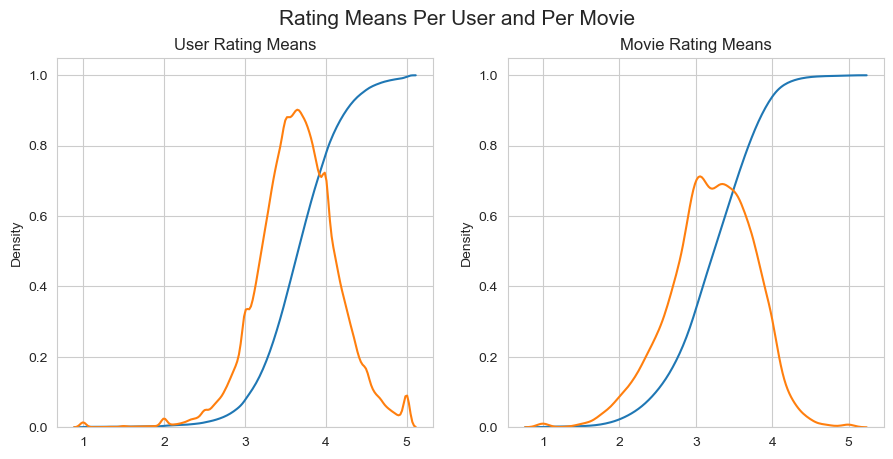

In [188]:
# Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.45))
fig.suptitle('Rating Means Per User and Per Movie', fontsize=15)

ax1.set_title('User Rating Means')

# Get the list of user rating means from the dictionary of means.
user_means = [rating for rating in train_means['user'].values()]
sns.distplot(user_means, ax=ax1, hist=False, kde_kws=dict(cumulative=True), label='CDF')
sns.distplot(user_means, ax=ax1, hist=False, label='PDF')

ax2.set_title('Movie Rating Means')

# Get the list of movie rating means from the dictionary.
movie_means = [rating for rating in train_means['movie'].values()]
sns.distplot(movie_means, ax=ax2, hist=False, kde_kws=dict(cumulative=True), label='CDF')
sns.distplot(movie_means, ax=ax2, hist=False, label='PDF')

plt.show()

## Cold Start

In [189]:
# Cold start for users
train_users = len(train_means['user'])
new_users = total_users - train_users

In [190]:
# Print
print('Total Users Overall:', total_users)
print('Total Users in Training Set:', train_users)
print("Total Users Not in Training Set: {} ({}%)".format(new_users, np.round((new_users / total_users) * 100, 2)))

Total Users Overall: 480189
Total Users in Training Set: 405041
Total Users Not in Training Set: 75148 (15.65%)


75148 usuários não fazem parte dos dados de treino, ou seja, não temos como aprender o padrão de avaliação desses usuários! Esse é o problema do cold start (ou início frio).

In [191]:
# Cold start for movies
train_movies = len(train_means['movie'])
new_movies = total_movies - train_movies

In [192]:
# Print
print('Total Movies Overall:', total_movies)
print('Total Movies in Training Set:', train_movies)
print("Total Movies Not in Training Set: {} ({}%)".format(new_movies, np.round((new_movies / total_movies) * 100, 2)))

Total Movies Overall: 17770
Total Movies in Training Set: 17424
Total Movies Not in Training Set: 346 (1.95%)


346 filmes não aparecem nos dados de treino. Teremos que lidar com isso quando trabalharmos especialmente no modelo de Machine Learning.

## Similarity Matrix for Users

In [193]:
# Function for calculating user similarity
def calculate_user_similarity(sparse_matrix, compute_for_few=False, top=100, verbose=False, verb_for_n_rows=20, draw_time_taken=True):
    
    # Control variables
    no_of_users, _ = sparse_matrix.shape
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind))
    time_taken = list()
    rows, cols, data = list(), list(), list()
    if verbose:
        print("Calculating top", top, "similarities for each user...")
    start = datetime.now()
    temp = 0
    
    # Loop through the matrix
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp + 1
        prev = datetime.now()
        
        # Calculating cosine similarity
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("Calculation completed for {} users [total time: {}]".format(temp, datetime.now()-start))
            
    if verbose: 
        print('Creating sparse matrix from computed similarities...')
        
    if draw_time_taken:
        plt.plot(time_taken, label='Calculation time for each user')
        plt.plot(np.cumsum(time_taken), label='Total Time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken

Calculating top 100 similarities for each user...
Calculation completed for 20 users [total time: 0:01:08.630564]
Calculation completed for 40 users [total time: 0:02:17.592648]
Calculation completed for 60 users [total time: 0:03:24.584164]
Calculation completed for 80 users [total time: 0:04:30.815250]
Calculation completed for 100 users [total time: 0:05:37.505179]
Creating sparse matrix from computed similarities...


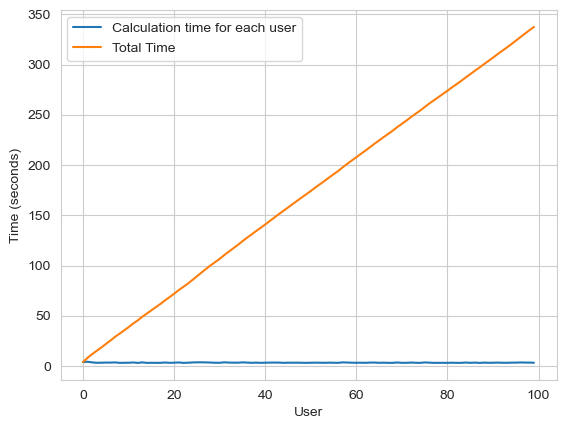

Total Processing Time: 0:05:44.685504


In [194]:
# Calculate similarity

# Mark the start
start = datetime.now()

# Calculate similarity
sparse_user_similarity, _ = calculate_user_similarity(sparse_matrix_train, 
                                                      compute_for_few=True, 
                                                      top=100, 
                                                      verbose=True)

print("Total Processing Time:", datetime.now() - start)

We have 405,041 users in our training set, and computing similarities among them (a 17K-dimensional vector) is time-consuming.

We will attempt to reduce the dimensions using SVD to speed up the process.

## Dimension Reduction with TruncatedSVD

In [195]:
# Dimensionality Reduction

# Mark the start
start = datetime.now()

# Create TruncatedSVD object reducing the dimensionality to 500 dimensions
netflix_svd = TruncatedSVD(n_components=10, algorithm='randomized', random_state=15)

# Apply TruncatedSVD
truncated_svd = netflix_svd.fit_transform(sparse_matrix_train)

print("Total Processing Time:", datetime.now() - start)

Total Processing Time: 0:00:26.469599


Let's calculate the variance explained by the components.

In [196]:
# Calculating the variance
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)

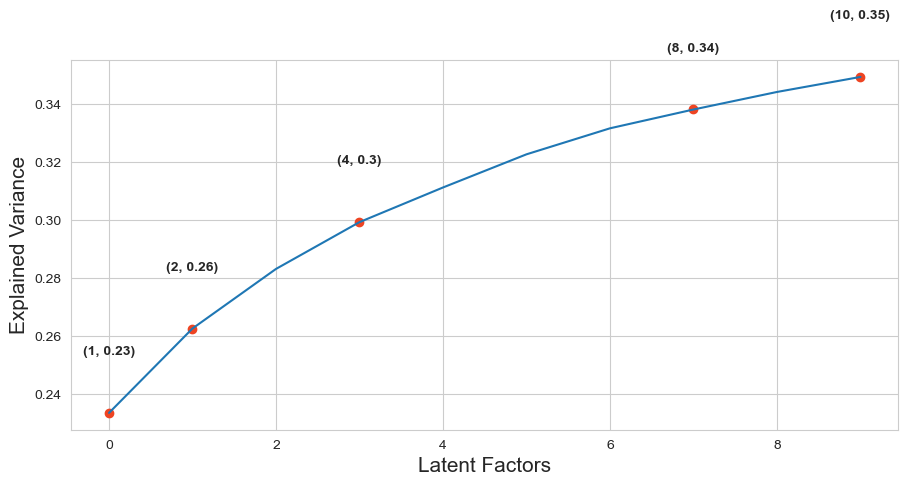

In [197]:
# Plot
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(.45))

ax1.set_ylabel("Explained Variance", fontsize=15)
ax1.set_xlabel("Latent Factors", fontsize=15)
ax1.plot(expl_var)

# Let's mark some combinations of (latent factors, explained variance) to make the plot clearer
ind = [1, 2, 4, 8, 10]
ax1.scatter(x=[i - 1 for i in ind], y=expl_var[[i - 1 for i in ind]], c='#ee4422')

for i in ind:
    ax1.annotate("({}, {})".format(i, np.round(expl_var[i - 1], 2)), xy=(i - 1, expl_var[i - 1]),
                 xytext=(i - 1, expl_var[i - 1] + 0.02), fontweight='bold', ha='center')

plt.show()


With 500 components, we explain approximately 65% of the variance in the data. This is sufficient for our example.

In [198]:
# Let's project our matrix into the 500-dimensional space
start = datetime.now()
trunc_matrix = sparse_matrix_train.dot(netflix_svd.components_.T)
print("Processing Time:", datetime.now() - start)


Processing Time: 0:00:00.780161


In [199]:
# Shape
trunc_matrix.shape

(2649430, 10)

In [200]:
# Tipo
type(trunc_matrix)

numpy.ndarray

In [201]:
# Let's create and save the matrix with reduced dimensionality to 500 dimensions
if not os.path.isfile('data/sparse_matrix_user_trunc.npz'):
    sparse_matrix_user_trunc = sparse.csr_matrix(trunc_matrix)
    sparse.save_npz('data/sparse_matrix_user_trunc', sparse_matrix_user_trunc)
else:
    matriz_esparsa_user_truncada = sparse.load_npz('data/sparse_matrix_user_trunc.npz')

In [202]:
# Getting shape
sparse_matrix_user_trunc.shape

(2649430, 10)

Now we calculate user similarity again using the truncated matrix.

Calculating top 50 similarities for each user...
Calculation completed for 20 users [total time: 0:00:04.377764]
Calculation completed for 40 users [total time: 0:00:08.732103]
Creating sparse matrix from computed similarities...


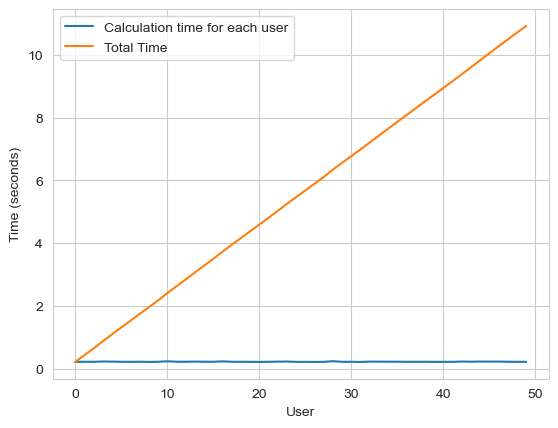

Processing Time: 0:00:12.102666


In [203]:
# Calculate user similarity

# Mark the start
start = datetime.now()

# Calculate the similarity
trunc_sim_matrix, _ = calculate_user_similarity(sparse_matrix_user_trunc, 
                                         compute_for_few=True, 
                                         top=50, 
                                         verbose=True)

print("Processing Time:", datetime.now() - start)

## Caculating the Movie Similarity Matrix

In [204]:
# Calculation of movie similarity

# Mark the start
start = datetime.now()

# Create if it doesn't exist
if not os.path.isfile('data/movie_sparse_matrix.npz'):
    movie_sparse_matrix = cosine_similarity(X=sparse_matrix_train.T, dense_output=False)
    print("Matrix Created.")
    sparse.save_npz("data/movie_sparse_matrix.npz", movie_sparse_matrix)
    print("Matrix Saved to Disk.")
else:
    movie_sparse_matrix = sparse.load_npz("data/movie_sparse_matrix.npz")
    print("Matrix Loaded.")

print("Processing Time:", datetime.now() - start)

Matrix Loaded.
Processing Time: 0:00:15.636559


In [205]:
# Shape
movie_sparse_matrix.shape

(17771, 17771)

In [206]:
# Getting movie id
movie_ids = np.unique(movie_sparse_matrix.nonzero()[1])

In [207]:
# Calculating the similarity based on the ratings

# Beggining time
start = datetime.now()

# Dict to store data
similar_movies = dict()

# Movie id loop
for movie in movie_ids:
    # Top 100 similar movies
    movie_sim = movie_sparse_matrix[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = movie_sim[:100]
    
print("Processing Time:", datetime.now() - start)

Processing Time: 0:00:33.663043


In [208]:
# Similar movies to movie id 120
similar_movies[120]

array([14714,  9769,  4997,  6359,  7560, 15524,  7863,  2155,  9015,
       15323, 10975, 14551,  4377,  9140,  2999, 14784,  9847,  9821,
         414, 16379,  2589,  9073, 11572, 11425,  2211,  6346,  1995,
        1990, 15399,  9531,  7059,  7848,  9180,  2451, 12499,  4398,
       14467,  2432, 16658, 15611,  4199, 10932,  9278, 15247, 16865,
       16204,  3094, 16832,  5286,  2338,  7238, 14409,    42,   701,
        8734, 17761,  1294,  3703,  8104,  2972, 16588,   557, 16572,
       11269, 12369, 14976, 12393,  2538,  4858,  4336,  1004,  9050,
        5185, 14333, 12729,    26, 14864,  8513,  4753,  9137, 15369,
       16737,  4492,  4771,  8153,  6673, 16192, 12856, 13288,  1305,
        4165, 16210,   363, 14762,  2574,  5281,  3829, 17051, 15620,
        6782], dtype=int64)

Now let's find the most similar movies using the similarity matrix.

In [209]:
# Let's load the movie titles from the CSV file provided by Netflix
movie_titles = pd.read_csv("data/movie_titles.csv", 
                             sep=',', 
                             header=None,
                             on_bad_lines = 'warn',
                             names=['Movie_ID', 'Release_year', 'Title'], 
                             verbose=True,
                             index_col='Movie_ID', 
                             encoding="ISO-8859-1")

Tokenization took: 5.19 ms
Type conversion took: 7.00 ms
Parser memory cleanup took: 0.00 ms


Skipping line 264: expected 3 fields, saw 5
Skipping line 350: expected 3 fields, saw 4
Skipping line 366: expected 3 fields, saw 4
Skipping line 394: expected 3 fields, saw 4
Skipping line 466: expected 3 fields, saw 4
Skipping line 582: expected 3 fields, saw 4
Skipping line 600: expected 3 fields, saw 4
Skipping line 670: expected 3 fields, saw 4
Skipping line 672: expected 3 fields, saw 4
Skipping line 729: expected 3 fields, saw 4
Skipping line 776: expected 3 fields, saw 4
Skipping line 827: expected 3 fields, saw 4
Skipping line 834: expected 3 fields, saw 4
Skipping line 891: expected 3 fields, saw 4
Skipping line 913: expected 3 fields, saw 4
Skipping line 944: expected 3 fields, saw 4
Skipping line 973: expected 3 fields, saw 4
Skipping line 1010: expected 3 fields, saw 4
Skipping line 1015: expected 3 fields, saw 4
Skipping line 1058: expected 3 fields, saw 4
Skipping line 1095: expected 3 fields, saw 4
Skipping line 1170: expected 3 fields, saw 4
Skipping line 1210: expecte

In [210]:
# Checking movie titles dataframe
movie_titles.head()

,Release_year,Title
Movie_ID,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


__Vejamos quais são os filmes similares ao filme de ID 120.__

In [211]:
# ID do filme
Movie_ID = 120

In [212]:
# Print
print("Movie:", movie_titles.loc[Movie_ID].values[1])
print("Total User Ratings =", sparse_matrix_train[:, Movie_ID].getnnz())
print("Found {} movies that are similar to this one, and we'll print the most similar ones.".format(movie_sparse_matrix[:, Movie_ID].getnnz()))


Movie: Plain Dirty
Total User Ratings = 303
Found 17251 movies that are similar to this one, and we'll print the most similar ones.


In [213]:
# Finding all similarities
similarities = movie_sparse_matrix[Movie_ID].toarray().ravel()
similar_index = similarities.argsort()[::-1][1:]
similarities[similar_index]
similar_index = similarities.argsort()[::-1][1:] 

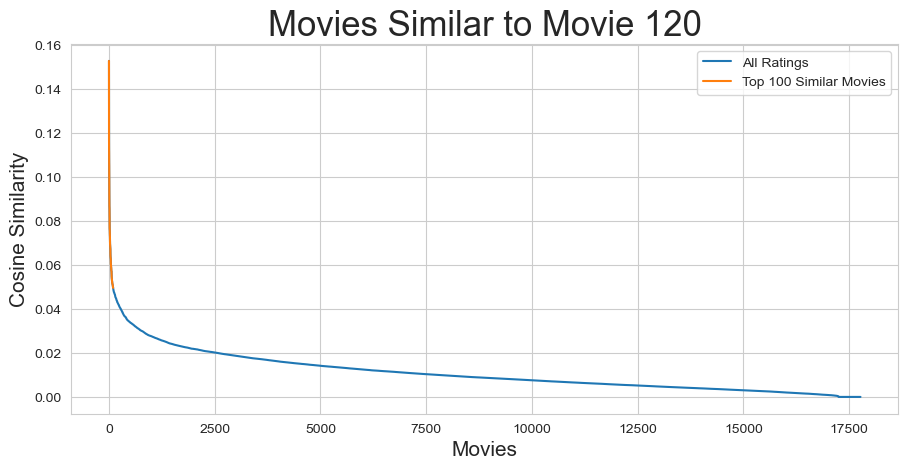

In [214]:
# Plot
fig = plt.figure(figsize=plt.figaspect(.45))
plt.plot(similarities[similar_index], label='All Ratings')
plt.plot(similarities[similar_index[:100]], label='Top 100 Similar Movies')
plt.title("Movies Similar to Movie {}".format(Movie_ID), fontsize=25)
plt.xlabel("Movies", fontsize=15)
plt.ylabel("Cosine Similarity", fontsize=15)
plt.legend()
plt.show()


In [215]:
# Aqui os top 10 filmes mais similares ao filme 120
movie_titles.loc[similar_index[:11]]

,Release_year,Title
Movie_ID,,
14714,2004.0,Gone Dark
9769,2001.0,Dead in the Water
4997,2004.0,Alabama Love Story
6359,2002.0,My Little Eye
7560,2002.0,New Best Friend
15524,2001.0,A Woman's a Helluva Thing
7863,2003.0,Shelter Island
2155,2003.0,Tempo
9015,2004.0,Cruel Intentions 3


# Next Steps